In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import torch


def seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
# 1. CSV 불러오기
df = pd.read_csv("ISCX-VPN-NonVPN_data/Scenario A1-ARFF/Scenario A1-ARFF_15s-VPN.csv")
le = LabelEncoder()
df['class1'] = le.fit_transform(df['class1'])

# 1. CSV 불러오기
df_preprocess = pd.read_csv("preprocessed_data/Scenario A1-ARFF/Scenario A1-ARFF_15s-VPN.csv")
le = LabelEncoder()
df_preprocess['class1'] = le.fit_transform(df_preprocess['class1'])

In [8]:
# def corr_remove(df):
#     fig, ax = plt.subplots(figsize=(14, 14))

#     # 상관관계 히트맵
#     corr = df.corr()
#     sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
#     ax.set_title('Correlation Heatmap')

#     plt.tight_layout()
#     plt.show()

#     remove_col = []

#     # 1. 상수값 컬럼
#     for col in df.columns:
#         if df[col].nunique() <= 1:
#             print(f"{col} 는 상수 — 제거 대상")
#             remove_col.append(col)

#     # 2. class1과 상관관계가 거의 없는 컬럼
#     low_corr_features = corr['class1'].abs()[corr['class1'].abs() < 0.1].index.tolist()
#     for col in low_corr_features:
#         if col not in remove_col:
#             print(f"{col} 는 상관관계가 거의 없음 - 제거 대상")
#             remove_col.append(col)

#     # 3. 상호 상관관계가 0.9 이상인 컬럼 쌍 중 하나 제거
#     high_corr_pairs = []
#     for i in corr.columns:
#         for j in corr.columns:
#             if i != j and abs(corr.loc[i, j]) > 0.9:
#                 pair = tuple(sorted((i, j)))
#                 if pair not in high_corr_pairs:
#                     high_corr_pairs.append(pair)

#     # 쌍 중 하나만 제거 (여기선 두 번째 항목 j를 제거)
#     for i, j in high_corr_pairs:
#         if j not in remove_col:
#             print(f"{i} 와 {j} 의 상관관계가 0.9 이상 {j} - 제거 대상")
#             remove_col.append(j)

#     # 중복 제거
#     remove_col = list(set(remove_col))
#     remove_col.sort()
#     print("최종 제거할 컬럼들:", len(remove_col), remove_col)

#     # 4. 실제 삭제
#     df_cleaned = df.drop(columns=remove_col)
#     return df_cleaned

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind

def corr_remove(df):
    fig, ax = plt.subplots(figsize=(14, 14))

    # 상관관계 히트맵 시각화
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
    ax.set_title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    remove_col = []

    # 1. 상수값 컬럼 제거
    for col in df.columns:
        if df[col].nunique() <= 1:
            print(f"{col} 는 상수 — 제거 대상")
            remove_col.append(col)

    # 3. class1 기준 t-test로 유의미한 차이 없는 컬럼 제거
    if 'class1' in df.columns and df['class1'].nunique() == 2:
        group0 = df[df['class1'] == 0]
        group1 = df[df['class1'] == 1]

        for col in df.columns:
            if col == 'class1' or col in remove_col:
                continue

            try:
                t_stat, p_val = ttest_ind(group0[col], group1[col], equal_var=False, nan_policy='omit')
                if p_val > 0.05:
                    print(f"{col} 는 t-test 결과 유의하지 않음 (p={p_val:.4f}) - 제거 대상")
                    remove_col.append(col)
            except Exception as e:
                print(f"{col} 처리 중 오류 발생: {e}")
                
    # 4. 상호 상관관계가 0.9 이상인 컬럼 쌍 중 하나 제거 (class와 무관)
    high_corr_pairs = []
    for i in corr.columns:
        for j in corr.columns:
            if i >= j:  # 중복 또는 자기 자신은 skip
                continue
            if abs(corr.loc[i, j]) > 0.9:
                pair = tuple(sorted((i, j)))
                high_corr_pairs.append(pair)

    # 중복 제거: 두 번째 컬럼을 제거
    for col1, col2 in high_corr_pairs:
        if col2 not in remove_col:
            print(f"{col1} 와 {col2} 의 상관관계가 0.9 이상 - {col2} 제거")
            remove_col.append(col2)

    # 최종 중복 제거 및 정렬
    remove_col = sorted(set(remove_col))
    print("\n✅ 최종 제거할 컬럼들:", len(remove_col), remove_col)

    # 실제 제거
    df_cleaned = df.drop(columns=remove_col)
    return df_cleaned

In [10]:
def train_test(df):
    # 특성과 레이블 나누기
    X = df.drop(columns=['class1'])
    y = df['class1']

    # train/valid/test 분리
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

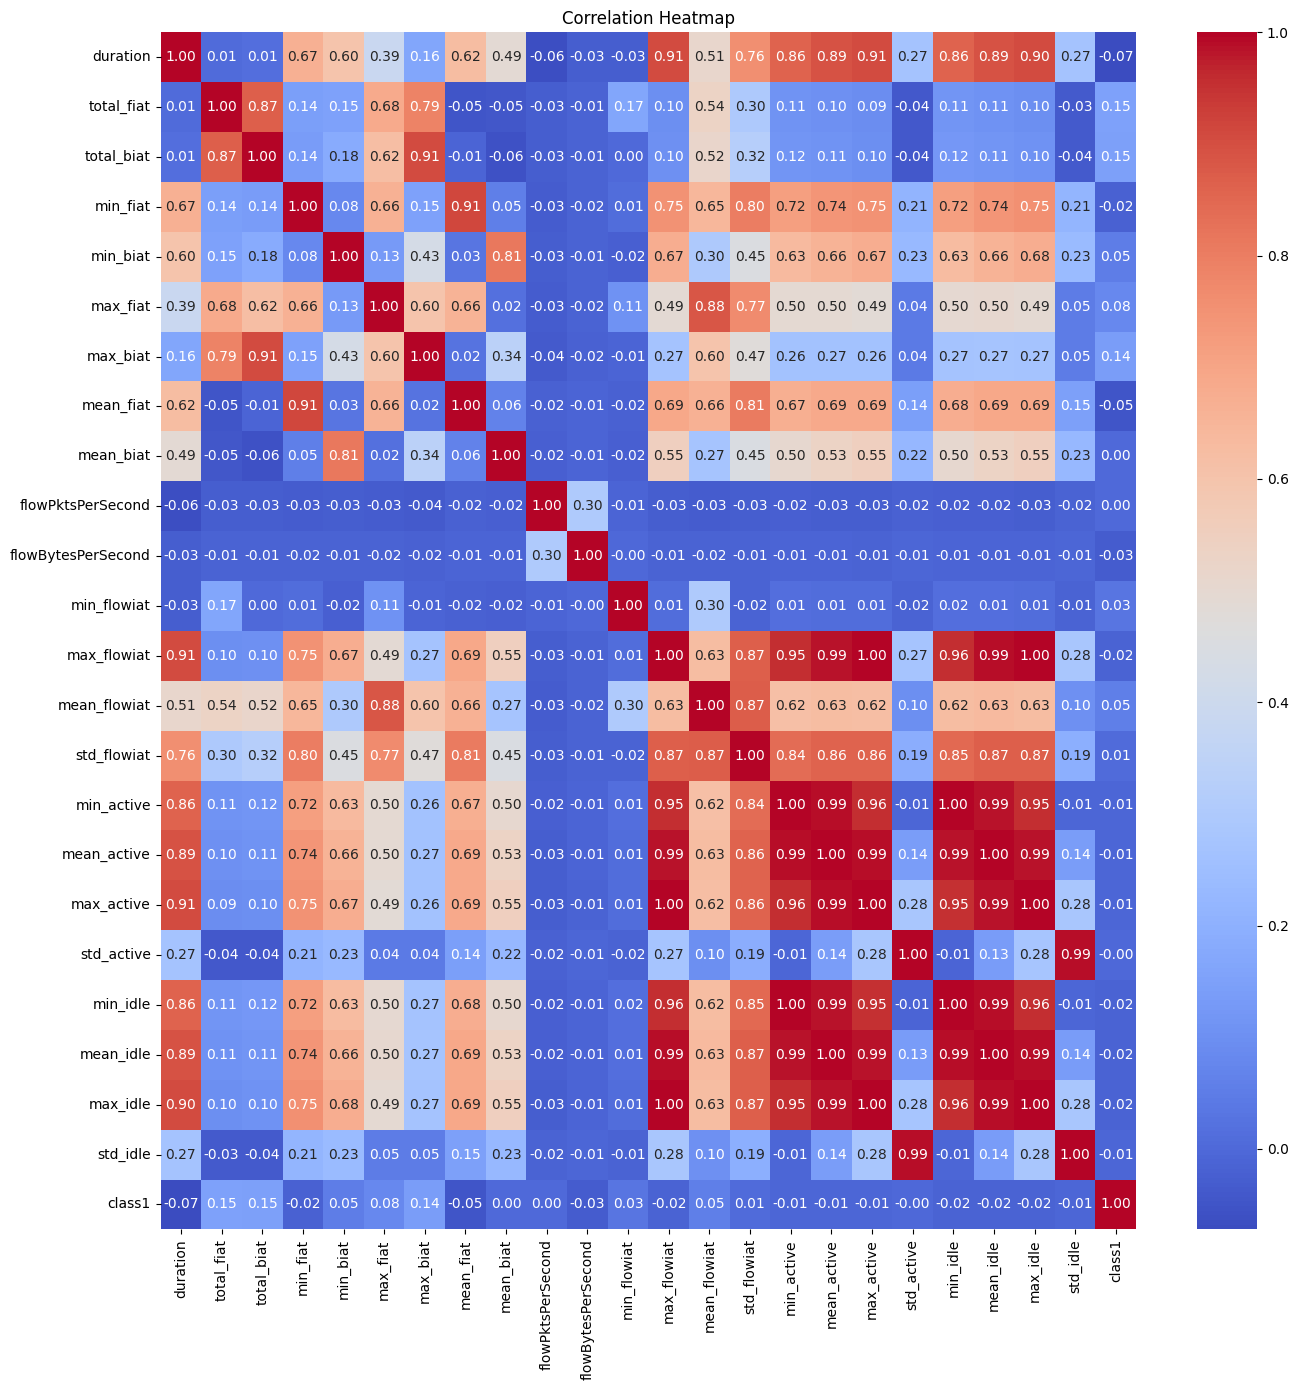

mean_biat 는 t-test 결과 유의하지 않음 (p=0.6651) - 제거 대상
flowPktsPerSecond 는 t-test 결과 유의하지 않음 (p=0.7054) - 제거 대상
std_flowiat 는 t-test 결과 유의하지 않음 (p=0.3973) - 제거 대상
min_active 는 t-test 결과 유의하지 않음 (p=0.2551) - 제거 대상
mean_active 는 t-test 결과 유의하지 않음 (p=0.2182) - 제거 대상
max_active 는 t-test 결과 유의하지 않음 (p=0.2316) - 제거 대상
std_active 는 t-test 결과 유의하지 않음 (p=0.5892) - 제거 대상
std_idle 는 t-test 결과 유의하지 않음 (p=0.3493) - 제거 대상
duration 와 max_flowiat 의 상관관계가 0.9 이상 - max_flowiat 제거
duration 와 max_idle 의 상관관계가 0.9 이상 - max_idle 제거
max_biat 와 total_biat 의 상관관계가 0.9 이상 - total_biat 제거
mean_fiat 와 min_fiat 의 상관관계가 0.9 이상 - min_fiat 제거
max_flowiat 와 min_idle 의 상관관계가 0.9 이상 - min_idle 제거
max_flowiat 와 mean_idle 의 상관관계가 0.9 이상 - mean_idle 제거

✅ 최종 제거할 컬럼들: 14 ['flowPktsPerSecond', 'max_active', 'max_flowiat', 'max_idle', 'mean_active', 'mean_biat', 'mean_idle', 'min_active', 'min_fiat', 'min_idle', 'std_active', 'std_flowiat', 'std_idle', 'total_biat']


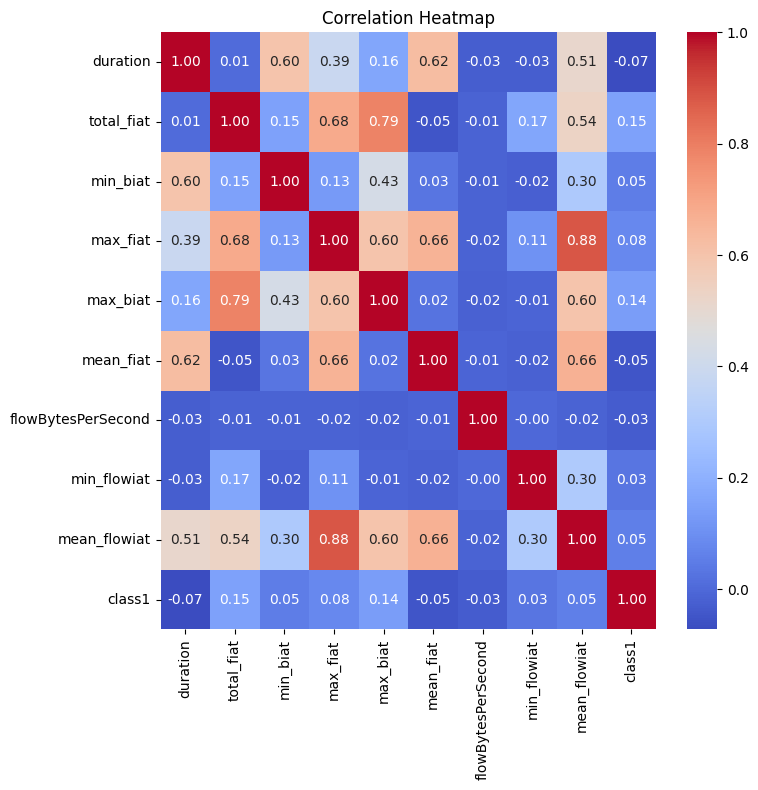

In [11]:
df_preprocess_cleaned = corr_remove(df_preprocess)

fig, ax = plt.subplots(figsize=(8, 8))

# 상관관계 히트맵
corr = df_preprocess_cleaned.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
ax.set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [12]:
seed()
X_train, y_train, X_valid, y_valid, X_test, y_test = train_test(df_preprocess_cleaned)

# 모델 학습
model = XGBClassifier(eval_metric='logloss', n_estimators=1000)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=50,
)

# 예측 및 평가 (문자 클래스 복원)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

[0]	validation_0-logloss:0.57407
[50]	validation_0-logloss:0.23917
[100]	validation_0-logloss:0.22017
[150]	validation_0-logloss:0.21557
[200]	validation_0-logloss:0.21750
[250]	validation_0-logloss:0.22198
[300]	validation_0-logloss:0.22481
[350]	validation_0-logloss:0.22820
[400]	validation_0-logloss:0.23305
[450]	validation_0-logloss:0.23764
[500]	validation_0-logloss:0.24159
[550]	validation_0-logloss:0.24448
[600]	validation_0-logloss:0.24862
[650]	validation_0-logloss:0.25318
[700]	validation_0-logloss:0.25537
[750]	validation_0-logloss:0.25909
[800]	validation_0-logloss:0.26222
[850]	validation_0-logloss:0.26427
[900]	validation_0-logloss:0.26731
[950]	validation_0-logloss:0.26924
[999]	validation_0-logloss:0.27169
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1738
           1       0.92      0.92      0.92      1870

    accuracy                           0.92      3608
   macro avg       0.92      0.92      0.92      3

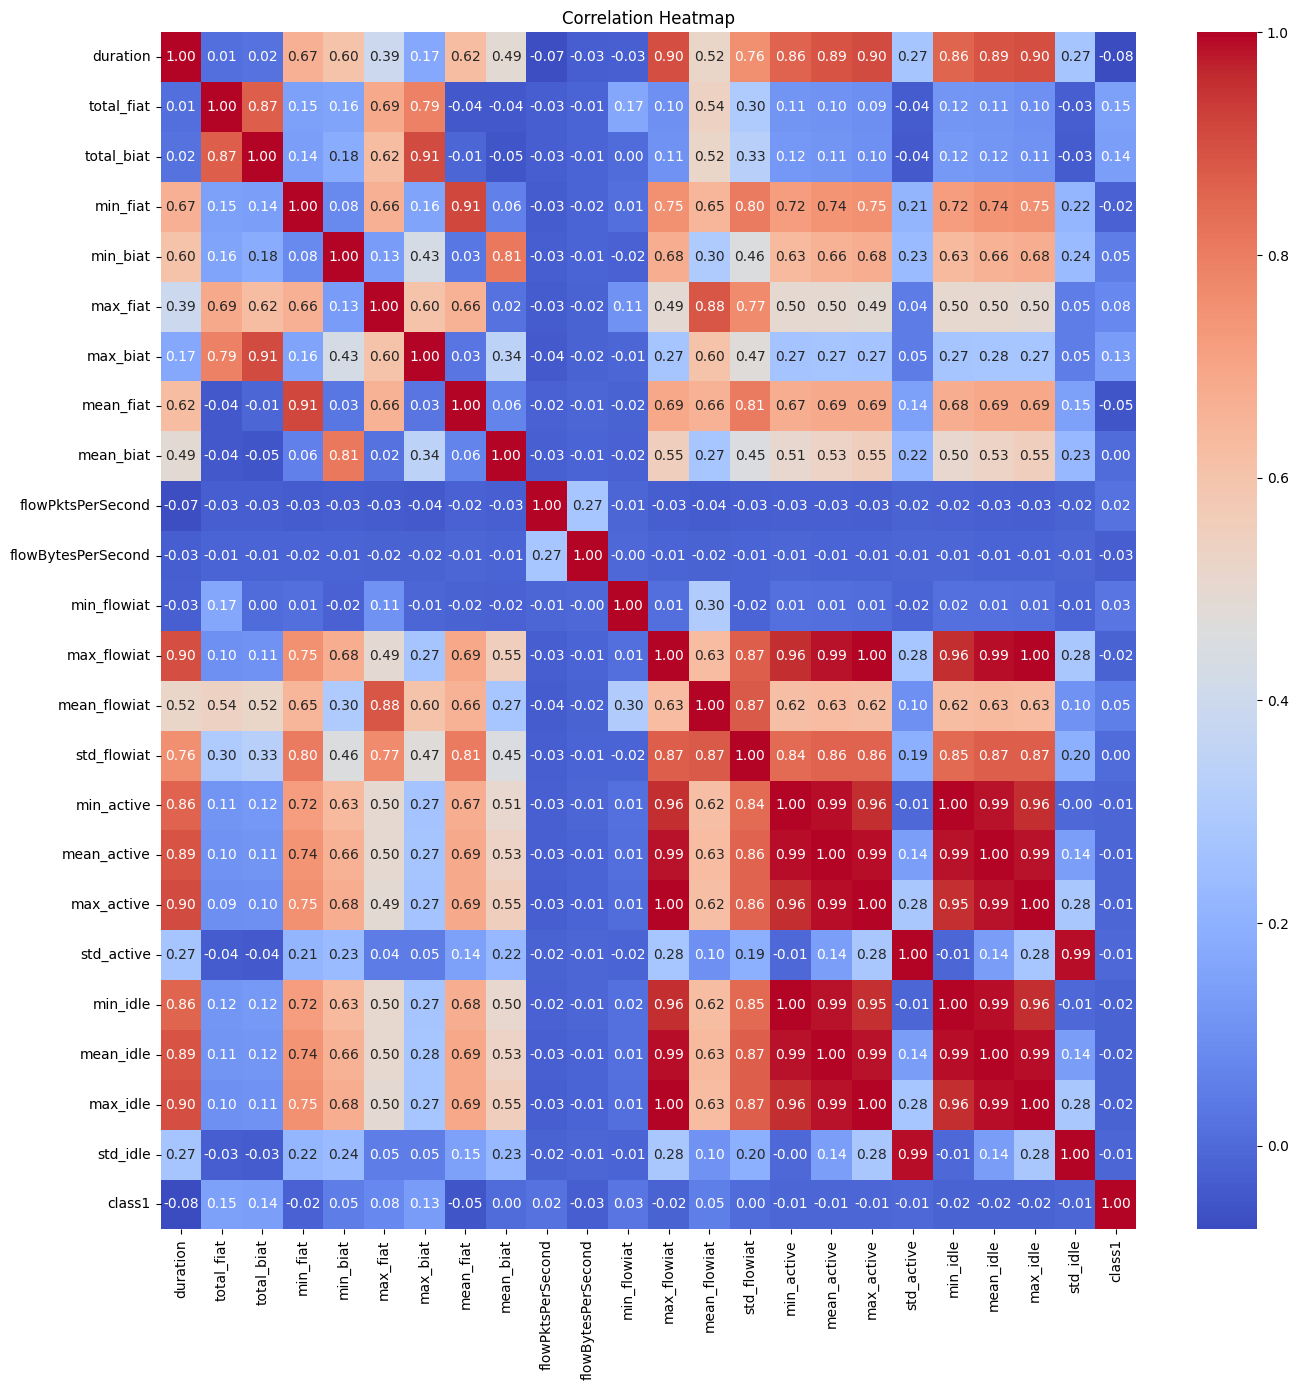

mean_biat 는 t-test 결과 유의하지 않음 (p=0.8522) - 제거 대상
std_flowiat 는 t-test 결과 유의하지 않음 (p=0.5797) - 제거 대상
min_active 는 t-test 결과 유의하지 않음 (p=0.1689) - 제거 대상
mean_active 는 t-test 결과 유의하지 않음 (p=0.1351) - 제거 대상
max_active 는 t-test 결과 유의하지 않음 (p=0.1380) - 제거 대상
std_active 는 t-test 결과 유의하지 않음 (p=0.4726) - 제거 대상
std_idle 는 t-test 결과 유의하지 않음 (p=0.2723) - 제거 대상
duration 와 max_flowiat 의 상관관계가 0.9 이상 - max_flowiat 제거
duration 와 max_idle 의 상관관계가 0.9 이상 - max_idle 제거
max_biat 와 total_biat 의 상관관계가 0.9 이상 - total_biat 제거
mean_fiat 와 min_fiat 의 상관관계가 0.9 이상 - min_fiat 제거
max_flowiat 와 min_idle 의 상관관계가 0.9 이상 - min_idle 제거
max_flowiat 와 mean_idle 의 상관관계가 0.9 이상 - mean_idle 제거

✅ 최종 제거할 컬럼들: 13 ['max_active', 'max_flowiat', 'max_idle', 'mean_active', 'mean_biat', 'mean_idle', 'min_active', 'min_fiat', 'min_idle', 'std_active', 'std_flowiat', 'std_idle', 'total_biat']


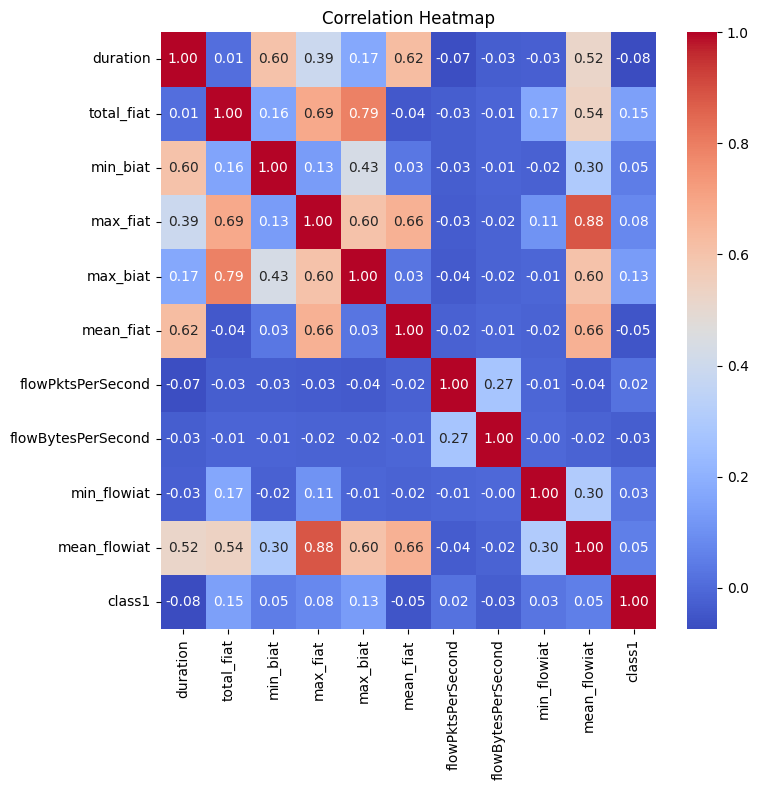

In [13]:
df_cleaned = corr_remove(df)

fig, ax = plt.subplots(figsize=(8, 8))

# 상관관계 히트맵
corr = df_cleaned.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
ax.set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [14]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_test(df_cleaned)

# 모델 학습
model = XGBClassifier(eval_metric='logloss', n_estimators=1000)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=50,
)

# 예측 및 평가 (문자 클래스 복원)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

[0]	validation_0-logloss:0.58365
[50]	validation_0-logloss:0.25696
[100]	validation_0-logloss:0.24405
[150]	validation_0-logloss:0.24249
[200]	validation_0-logloss:0.24290
[250]	validation_0-logloss:0.24699
[300]	validation_0-logloss:0.25139
[350]	validation_0-logloss:0.25499
[400]	validation_0-logloss:0.25917
[450]	validation_0-logloss:0.26496
[500]	validation_0-logloss:0.26885
[550]	validation_0-logloss:0.27294
[600]	validation_0-logloss:0.27624
[650]	validation_0-logloss:0.27941
[700]	validation_0-logloss:0.28248
[750]	validation_0-logloss:0.28629
[800]	validation_0-logloss:0.28935
[850]	validation_0-logloss:0.29222
[900]	validation_0-logloss:0.29526
[950]	validation_0-logloss:0.29839
[999]	validation_0-logloss:0.30008
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1793
           1       0.90      0.93      0.92      1959

    accuracy                           0.91      3752
   macro avg       0.91      0.91      0.91      3